In [1]:
import lhapdf
#import ROOT
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (7.6,4)
## Getting a PDF member object
p_cteq6 = lhapdf.mkPDF("cteq6l1", 0)
p_cteq18 = lhapdf.mkPDF("CT18qed",0)
JAM20_FF = lhapdf.mkPDF("JAM20-SIDIS_FF_pion_nlo", 0)
JAM20_PDF = lhapdf.mkPDF("JAM20-SIDIS_PDF_proton_nlo", 0)
from iminuit import Minuit
import sys
sys.path.insert(1,'DSS')
import fDSS_
sys.path.insert(1,'hkns07fflib-v1_2')
import hknsff07_
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit
import pandas as pd
# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares
i_rho = 1.8
# rho is subtracted in C++ file and saved in the csv input file. Need to change these whenever it's changed in C++ file
i_FF = 2
FF_model = ["fDSSLO","fDSSNLO","JAM20","hknsff07_LO","hknsff07_NLO","myDz","Geiger"]
i_PDF = 1
PDF_model = ["cteq6l1","JAM20","cteq18qed","nnPDF"]
df = pd.read_csv("results/csv.csv")

RY_str = 'RY_1p8rho'
#RY_str = 'RY_1p5rho'
#RY_str = 'RY_rho'

LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/cteq6l1/cteq6l1_0000.dat
cteq6l1 PDF set, member #0, version 4; LHAPDF ID = 10042
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/CT18qed/CT18qed_0000.dat
CT18qed PDF set, member #0, version 1
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/JAM20-SIDIS_FF_pion_nlo/JAM20-SIDIS_FF_pion_nlo_0000.dat
JAM20-SIDIS_FF_pion_nlo PDF set, member #0, version 2
LHAPDF 6.3.0 loading /Users/shuojia/CSV/lhapdf/build/share/LHAPDF/JAM20-SIDIS_PDF_proton_nlo/JAM20-SIDIS_PDF_proton_nlo_0000.dat
JAM20-SIDIS_PDF_proton_nlo PDF set, member #0, version 2


In [2]:
def Get_weighted(values,errs):
    sums = 0
    sig = 0
    for i in range(len(values)):
        for j in range(len(errs)):
            sums+=values[i]/(errs[i]*errs[i])
            sig+=1/(errs[i]*errs[i])
    return sums/sig   
def Get_weighted_average(value,error):
    sum_mean = 0
    sum_sigma = 0
    for i in range(len(value)):
        sum_mean += value[i]/(error[i]*error[i])
        sum_sigma += 1/(error[i]*error[i])
    return sum_mean/sum_sigma
def Get_weighted_sigma(value,error):
    sum_sigma = 0
    for i in range(len(value)):
        sum_sigma += 1/(error[i]*error[i])
    return math.sqrt(1/sum_sigma)


In [3]:
def Get_Delta_z(Q,z_had):
    if i_FF == 0:
        #fDSS lo
        duplus = fDSS_.fdss(1,1,0,z_had,Q*Q)[0]
        duminus = fDSS_.fdss(1,-1,0,z_had,Q*Q)[0]
        delta_z = duminus/duplus
        return delta_z
    elif i_FF == 1:
        #fDSS nlo
        duplus = fDSS_.fdss(1,1,1,z_had,Q*Q)[0]
        duminus = fDSS_.fdss(1,-1,1,z_had,Q*Q)[0]
        delta_z = duminus/duplus
        return delta_z
    elif i_FF == 2:
        duplus = JAM20_FF.xfxQ(2,z_had,Q)
        duminus = JAM20_FF.xfxQ(-2,z_had,Q)
        delta_z = duminus/duplus
        return delta_z
    elif i_FF==3:
        
        ff = np.zeros(11)
        grad = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_had,1,1,ff,grad)
        ff_minus = np.zeros(11)
        grad_minus = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_had,1,2,ff_minus,grad_minus)
        duplus = ff[6]
        dsplus = ff[8]
        duminus = ff_minus[6]
        dsminus = ff_minus[8]
        delta_z = duminus/duplus
        return delta_z
    elif i_FF==4:
        
        ff = np.zeros(11)
        grad = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_had,2,1,ff,grad)
        ff_minus = np.zeros(11)
        grad_minus = np.zeros((11,17))
        hknsff07_.hknsff(Q*Q,z_had,2,2,ff_minus,grad_minus)
        duplus = ff[6]
        dsplus = ff[8]
        duminus = ff_minus[6]
        dsminus = ff_minus[8]
        delta_z = duminus/duplus
        return delta_z
    elif i_FF ==6:
        #Ratio of D-/D+ from P.Geiger's thesis HERMES
        R_D = (1.0-z_had)**0.0083583/(1.0+z_had)**1.9838
        delta_z = R_D
        return delta_z
    elif i_FF ==5:
        params = [0.20913119336767483,1.3307868041697344]#for a_rho = 1.5
        def Dz_param(z_had,params):
            delta_z = z_had**params[0]*(1-z_had)**params[1]
            return (1-delta_z)/(1+delta_z)
        
        return Dz_param(z_had,params)

In [4]:
def Get_Yield_ratio(pos_D2,pos_D2_err,neg_D2,neg_D2_err):
    yield_ratio = neg_D2/pos_D2
    yield_ratio_err = yield_ratio*math.sqrt(pos_D2_err**2/pos_D2**2+neg_D2_err**2/neg_D2**2)
    return yield_ratio,yield_ratio_err

'''
#first equation
a = 1
pdf_name = 'equation1'
def du_from_yield_ratio(Q,x,z,yield_ratio,yield_ratio_err):
    Delta_z = Get_Delta_z(Q,z)
    #du_ratio = du/(u_v+d_v)
    du_ratio = ((4*Delta_z+1)-yield_ratio*(4+Delta_z))/(yield_ratio*(4-Delta_z)-(4*Delta_z-1))
    uv = JAM20_PDF.xfxQ(2,xbj,Q)-JAM20_PDF.xfxQ(-2,xbj,Q)
    dv = JAM20_PDF.xfxQ(1,xbj,Q)-JAM20_PDF.xfxQ(-1,xbj,Q)
    du = du_ratio*(uv+dv)
    coea = (4*Delta_z+1)/(4-Delta_z)-(4*Delta_z-1)*(4+Delta_z)/(4-Delta_z)**2
    coeb = (4*Delta_z-1)/(4-Delta_z)
    sig_du = coea*yield_ratio_err/(yield_ratio-coeb)**2
    sig_du = sig_du*(uv+dv)
    #sig_du = (uv+dv)*(((4*Delta_z+1)/(4*Delta_z)-((4*Delta_z-1)(4+Delta_z))/(4-Delta_z)**2)(yield_ratio_err/(yield_ratio-((4*Delta_z-1)/(4-Delta_z)))**2))
    #sig_du = (uv+dv)*du*(4-Delta_z)*yield_ratio_err/(yield_ratio*(4-Delta_z)-(4*Delta_z-1))
    return du,sig_du
    
'''
a = 1
#pdf_name = 'e2_1p5'
pdf_name = 'e2_1p8'
#pdf_name = 'e2'
#a = 0.5
#pdf_name = 'e2_a2'
#a = 0.25
#pdf_name = 'e2_a3_1p8'
#pdf_name = 'e2_a3'
#a = 4
#pdf_name = 'e2_a4'
#second equation

def du_from_yield_ratio(Q,x,z,yield_ratio,yield_ratio_err):
    Delta_z = Get_Delta_z(Q,z)
    u = JAM20_PDF.xfxQ(2,xbj,Q)
    ub = JAM20_PDF.xfxQ(-2,xbj,Q)
    d = JAM20_PDF.xfxQ(1,xbj,Q)
    db = JAM20_PDF.xfxQ(-1,xbj,Q)
    T = (ub+db)/(u+d)
    strange = JAM20_PDF.xfxQ(3,xbj,Q)
    sb = JAM20_PDF.xfxQ(-3,xbj,Q)
    S = 2*(strange+sb)/(u+d)

    Y = yield_ratio
    #du_ratio = du/(u+d)
    A = 4*Delta_z+T*Delta_z+S*Delta_z+1+4*T
    B = (4*T*Delta_z+Delta_z+S*Delta_z+4+T)
    C = 4*a-Delta_z
    D = (4*a*Delta_z-1)
    du_ratio = (A-B*Y)/(C*Y-D)
    #du_ratio = (4*Delta_z+T*Delta_z+S*Delta_z+1-Y*(4*T*Delta_z+Delta_z+S*Delta_z)-Y*(4+T))/((4*a-Delta_z)*Y-(4*a*Delta_z-1)) 
    du = du_ratio*(u+d)
    sig_du = B/C*(A*C/B-D)*C*yield_ratio_err/(C*yield_ratio-D)**2
    sig_du = sig_du*(u+d)
    return du,sig_du


In [5]:
Q2s = [3.80473,4.56863,5.19412]
Q2_str = ["4.000000","4.750000","5.500000"]

In [6]:
xbj_ones_corr = []
xbj_ones_err = []
CSV_ones = []
CSV_ones_err = []
xbj_ones_plot = []
CSV_ones_plot = []
CSV_ones_err_plot = []
xbj_twos_corr = []
xbj_twos_err = []
CSV_twos = []
CSV_twos_err = []
xbj_twos_plot = []
CSV_twos_plot = []
CSV_twos_err_plot = []
xbj_threes_corr = []
xbj_threes_err = []
CSV_threes = []
CSV_threes_err = []
xbj_threes_plot = []
CSV_threes_plot = []
CSV_threes_err_plot = []

/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/838461272.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zs = df[df['Q2']==4][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/838461272.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in df[df['Q2']==4][df['xbj']==xs[ix]][df['z']==iz].iterrows():


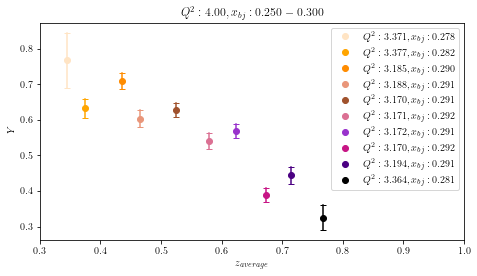

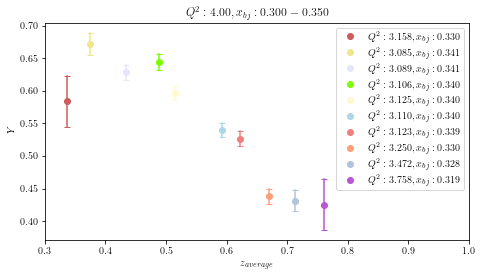

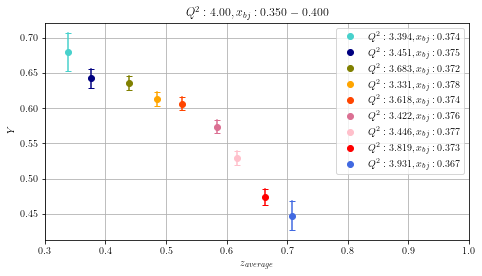

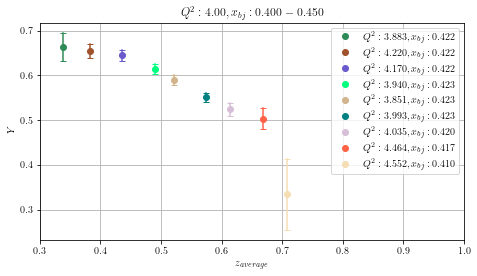

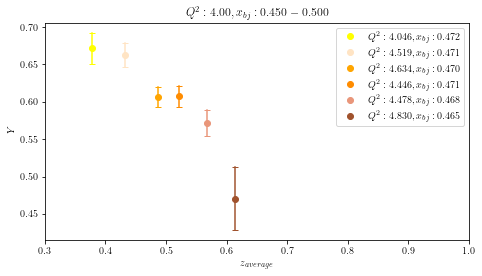

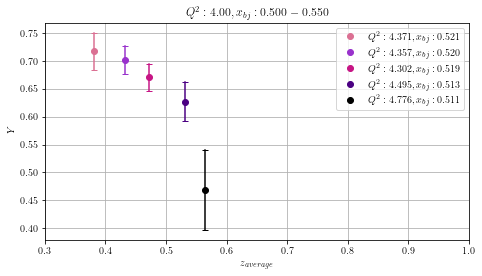

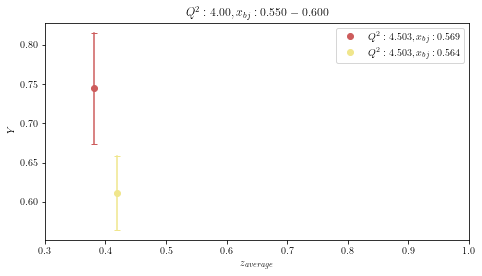

In [7]:

CSVs = []
CSVs_err = []
xbj_all_corr=[]
i_col = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','olive','orange','orangered','palevioletred','pink','red','royalblue','seagreen','sienna','slateblue','springgreen','tan','teal','thistle','tomato','wheat','yellow','bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','bisque','orange','darkorange','darksalmon','sienna','bisque','orange','darkorange','darksalmon','sienna']

xs = df[df['Q2']==4].sort_values('xbj')['xbj'].unique()
#print(xs)
#ax.errorbar(xs,zs,RDs,RD_err,marker = "_")
for ix in range(0,len(xs)):
    fig = plt.figure()
    ax = fig.add_subplot()
    xbj_one_corr = []
    xbj_one_err_corr = []
    CSV_one = []
    CSV_one_err = []
    #RD_err = []
    zs = df[df['Q2']==4][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
    #print(zs)
    xbj = xs[ix]
    for iz in zs:
        #print(iRunGroup)
        yield_ratios = []
        yield_ratio_errs = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        
        for i,row in df[df['Q2']==4][df['xbj']==xs[ix]][df['z']==iz].iterrows():
            zi_corr = row['z_corr']
            #print(z_corr)
            #yield_neg = row['yield_neg']
            #yield_pos = row['yield_pos']
            #error_neg = row['error_neg']
            #error_pos = row['error_pos']
            
            #print('RD_error ',RD_error)
            zs_corr.append(zi_corr)
            zi_corr_err = row["z_corr_err"]
            zs_corr_err.append(zi_corr_err)
            xbji_corr = row["xbj_corr"]
            xbji_corr_err = row["xbj_corr_err"]
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = row["Q2_corr"]
            Q2i_corr_err = row["Q2_corr_err"]
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            if Q2i_corr<3:
                print(Q2i_corr)
            
            yield_ratio = row[RY_str]
            yield_ratio_err = row["error"]
            #yield_ratio = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[0]
            #yield_ratio_err = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[1]
            yield_ratios.append(yield_ratio)
            yield_ratio_errs.append(yield_ratio_err)
            CSVxzi =du_from_yield_ratio(math.sqrt(Q2i_corr),xbji_corr,zi_corr,yield_ratio,yield_ratio_err)[0]
            CSVxzi_err =du_from_yield_ratio(math.sqrt(Q2i_corr),xbji_corr,zi_corr,yield_ratio,yield_ratio_err)[1]
            #CSVxzi_err = CSVx_err(math.sqrt(Q2i_corr),zi_corr,xbji_corr,RDi_error)
            CSV_ones.append(CSVxzi)
            CSV_ones_err.append(CSVxzi_err)
            xbj_ones_corr.append(xbji_corr)
            #print(xbji_corr)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        #print(xbj_corr)
        if abs(xbj_corr-xbj)>0.025:
            print(xbj_corr-xbj)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        Q2_corr = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        if Q2_corr<3:
            print("corr ",Q2_corr)
        yield_ratio_xi = Get_weighted_average(yield_ratios,yield_ratio_errs)
        yield_ratio_xi_err = Get_weighted_sigma(yield_ratios,yield_ratio_errs)
        ax.plot([z_corr,z_corr],[yield_ratio_xi+yield_ratio_xi_err,yield_ratio_xi-yield_ratio_xi_err],color = colors_all[i_col],marker = "_")
        plt.plot(z_corr,yield_ratio_xi,"o",color = colors_all[i_col],label = f"$Q^2:{Q2_corr:.3f},x_{{bj}}:{xbj_corr:.3f}$")
        xbj_all_corr.append(xbj_corr)
        #here CSV is combined for same kin point for plotting reason
        CSVxi = du_from_yield_ratio(math.sqrt(Q2_corr),xbj_corr,z_corr,yield_ratio_xi,yield_ratio_xi_err)[0]
        CSVxi_err = du_from_yield_ratio(math.sqrt(Q2_corr),xbj_corr,z_corr,yield_ratio_xi,yield_ratio_xi_err)[1]
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_one_corr.append(xbj_corr)
        xbj_onei_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_one_err_corr.append(xbj_onei_err_corr)
        CSV_one.append(CSVxi)
        CSV_one_err.append(CSVxi_err)
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$Y$')
        plt.xlim(0.3,1)
        plt.legend()
        plt.grid()
        ax.set_title(f"$Q^2:{Q2_str[0][0:4]},x_{{bj}}:{(xbj-0.025):.3f}-{(xbj+0.025):.3f}$")#str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
        i_col = i_col+1
                    
    xbj_one = Get_weighted_average(xbj_one_corr,xbj_one_err_corr)
    xbj_ones_plot.append(xbj_one)
    #print(xbj_one_corr)
    #print('corredted',xbj_one)
    xbj_one_err = Get_weighted_average(xbj_one_corr,xbj_one_err_corr)
    #xbj_ones_err.append(xbj_one_err)
    #print('CSVs',CSV_one)
    #print('CSCVs err',CSV_one_err)
    CSVxi_one = Get_weighted_average(CSV_one,CSV_one_err)
    CSVxi_one_err = Get_weighted_sigma(CSV_one,CSV_one_err)
    #print('CSV one', CSVxi_one)
    #print('CSV one err',CSVxi_one_err)
    #print(CSV_one_err)
    #print(CSVxi_one_err)
    
    CSV_ones_plot.append(CSVxi_one)
    CSV_ones_err_plot.append(CSVxi_one_err)
    sys_out = "4.0,"+str(xbj)+","+str(xbj_one)+","+FF_model[i_FF]+","+PDF_model[i_PDF]+","+str(i_rho)+","+str(CSVxi_one)+","+str(CSVxi_one_err)+"\n"
    #sys_out = ['4',str(Q2_corr),str(ix),str(xbj_corr),str(iz),str(z_corr),FF_model[i_FF],str(i_rho)]
    with open('results/csv_systematic.txt','a',encoding='UTF8') as f_sys:
        f_sys.write(sys_out)   

/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/557605122.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zs = df[df['Q2']==4][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/557605122.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in df[df['Q2']==4][df['xbj']==xs[ix]][df['z']==iz].iterrows():
/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/557605122.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zs = df[df['Q2']==4][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/557605122.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in df[df['Q2']==4][df['xbj']==xs[ix]][df['z']==iz].iterrows():


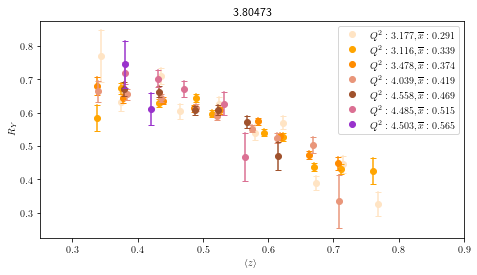

In [8]:
i_col = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','olive','orange','orangered','palevioletred','pink','red','royalblue','seagreen','sienna','slateblue','springgreen','tan','teal','thistle','tomato','wheat','yellow','bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','bisque','orange','darkorange','darksalmon','sienna','bisque','orange','darkorange','darksalmon','sienna']
Q2 = Q2s[0]

xs = df[df['Q2']==4].sort_values('xbj')['xbj'].unique()
#print(xs)
#ax.errorbar(xs,zs,RDs,RD_err,marker = "_")
fig = plt.figure()
ax = fig.add_subplot()
for ix in range(0,len(xs)):
    
    xbj = xs[ix]
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RY_alls = []
    xbj_corr_xbj = []
    xbj_err_xbj = []
    Q2_corr_xbj = []
    Q2_err_xbj = []
    zs = df[df['Q2']==4][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
    for iz in zs:
        z_hadron = zs
        RYs = []
        RYs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        
        for i,row in df[df['Q2']==4][df['xbj']==xs[ix]][df['z']==iz].iterrows():
            #yield_neg = row['yield_neg']
            #yield_pos = row['yield_pos']
            #error_neg = row['error_neg']
            #error_pos = row['error_pos']
            #yield_ratio = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[0]
            #yield_ratio_err = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[1]
            yield_ratio = row[RY_str]
            yield_ratio_err = row['error']
            
            RYs.append(yield_ratio)
            RYs_error.append(yield_ratio_err)
            zi_corr = row["z_corr"]
            zs_corr.append(zi_corr)
            zi_corr_err = row["z_corr_err"]
            zs_corr_err.append(zi_corr_err)
            xbji_corr = row["xbj_corr"]
            xbji_corr_err = row["xbj_corr_err"]
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = row["Q2_corr"]
            Q2i_corr_err = row["Q2_corr_err"]
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        Q2_corr_z = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        Q2_err_z = Get_weighted_sigma(Q2s_corr,Q2s_corr_err)
        Q2_corr_xbj.append(Q2_corr_z)
        Q2_err_xbj.append(Q2_err_z)
        xbj_corr_z = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_corr_err_z = Get_weighted_sigma(xbjs_corr,xbjs_corr_err)
        xbj_corr_xbj.append(xbj_corr_z)
        xbj_err_xbj.append(xbj_corr_err_z)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RY = Get_weighted_average(RYs,RYs_error)
        RY_err = Get_weighted_sigma(RYs,RYs_error)
        
        z_corrs.append(z_corr)
        RY_alls.append(RY)
        plt.plot([z_corr,z_corr],[RY+RY_err,RY-RY_err],marker = "_",color = colors_all[i_col])
    Q2_corr = Get_weighted_average(Q2_corr_xbj,Q2_err_xbj)
    xbj_corr = Get_weighted_average(xbj_corr_xbj,xbj_err_xbj)
    plt.plot(z_corrs,RY_alls,"o",label = f"$Q^2:{Q2_corr:.3f},\overline{{x}} :{xbj_corr:.3f}$",color = colors_all[i_col])#Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R_Y$')
    plt.xlim(0.25,0.9)
    plt.legend()
    #plt.ylim(0,10)
    plt.title(Q2)
    i_col +=1
    plt.savefig('notebook_results/RY_1stQ2.pdf')

Text(0, 0.5, 'CSV')

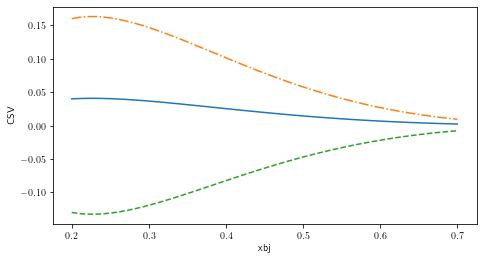

In [9]:
def delta_udv(parameter):
    #x = np.arange(0.2,0.7,0.01)
    x = np.linspace(0.2,0.7,50)
    return parameter*(1-x)**4*x**-0.5*(x-0.0909)
#x_axis = np.arange(0.2,0.7,0.01)
x_axis = np.linspace(0.2,0.7,50)
y_delta_uv = delta_udv(-0.2)
y_delta_dv = delta_udv(0.2)
y_delta_uv_up = delta_udv(0.8)
y_delta_uv_low = delta_udv(-0.8)
y_delta_dv_up = delta_udv(-0.65)
y_delta_dv_low = delta_udv(0.65)

    
plt.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV')


plt.plot(x_axis,y_delta_uv_up-y_delta_uv_low,'-.')
plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--')
plt.xlabel('xbj')
plt.ylabel('CSV')
#plt.ylim(-0.1,0.15)

Text(0, 0.5, '$\\delta u$')

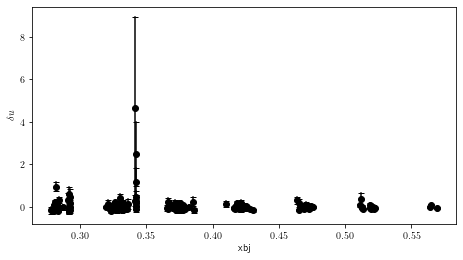

In [10]:
fig, ax = plt.subplots()
for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]-CSV_ones_err[i],CSV_ones[i]+CSV_ones_err[i]],marker = "_",color = "k")
plt.plot(xbj_ones_corr,CSV_ones,"ko",label = Q2)

#print(xbj_ones_corr)
    

#ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
#ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'MRST',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$\delta u$')

Text(0, 0.5, '$\\delta u$')

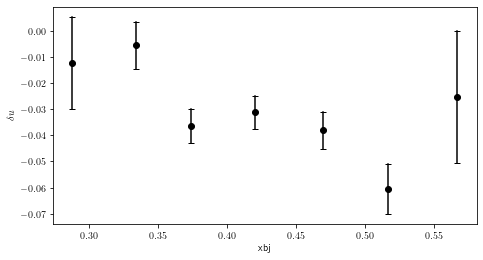

In [11]:
for i in range(len(CSV_ones_plot)):
    plt.plot([xbj_ones_plot[i],xbj_ones_plot[i]],[CSV_ones_plot[i]-CSV_ones_err_plot[i],CSV_ones_plot[i]+CSV_ones_err_plot[i]],marker = "_",color = "k")
plt.plot(xbj_ones_plot,CSV_ones_plot,"ko")
        

#ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
#ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$\delta u$')

Text(0, 0.5, '$CSV$')

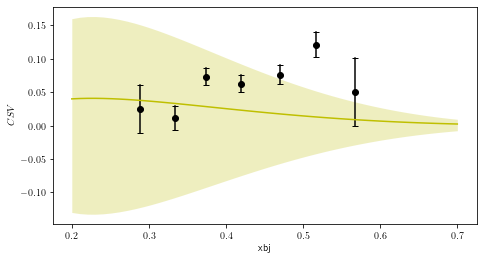

In [12]:
fig, ax = plt.subplots()
for i in range(len(CSV_ones_plot)):
    plt.plot([xbj_ones_plot[i],xbj_ones_plot[i]],[-2*CSV_ones_plot[i]-2*CSV_ones_err_plot[i],-2*CSV_ones_plot[i]+2*CSV_ones_err_plot[i]],marker = "_",color = "k")
plt.plot(xbj_ones_plot,-2*np.asarray(CSV_ones_plot),"ko")
        

ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$CSV$')

/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/1115373099.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zs = df[df['Q2']==4.75][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/1115373099.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in df[df['Q2']==4.75][df['xbj']==xs[ix]][df['z']==iz].iterrows():


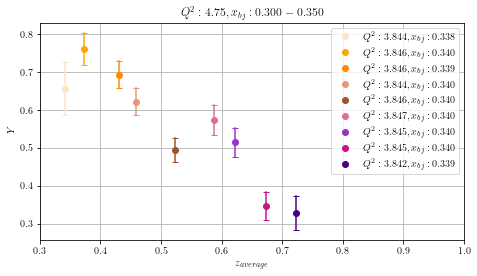

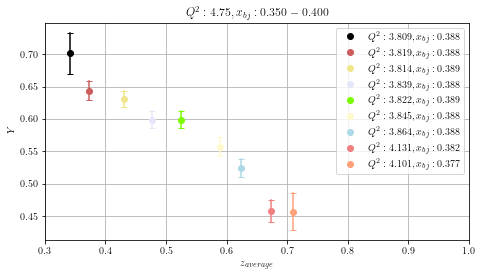

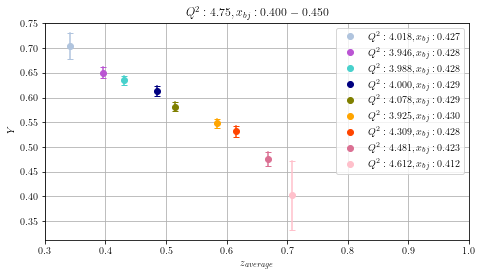

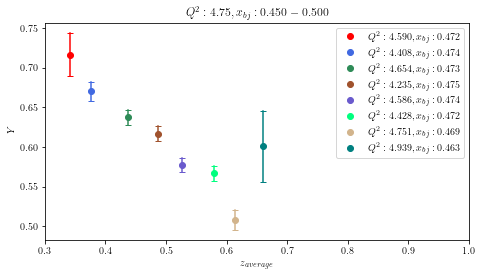

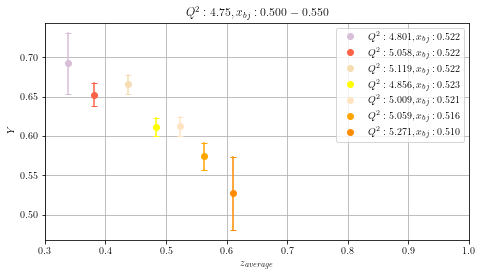

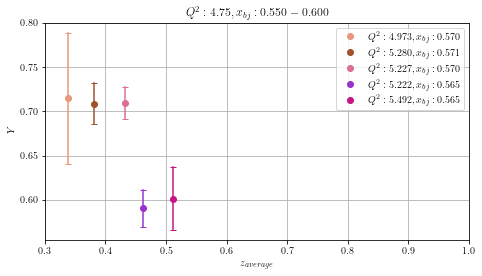

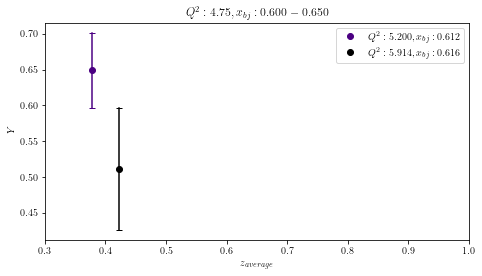

In [13]:

CSVs = []
CSVs_err = []
xbj_all_corr=[]
i_col = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','olive','orange','orangered','palevioletred','pink','red','royalblue','seagreen','sienna','slateblue','springgreen','tan','teal','thistle','tomato','wheat','yellow','bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','bisque','orange','darkorange','darksalmon','sienna','bisque','orange','darkorange','darksalmon','sienna']

xs = df[df['Q2']==4.75].sort_values('xbj')['xbj'].unique()
#print(xs)
#ax.errorbar(xs,zs,RDs,RD_err,marker = "_")
for ix in range(0,len(xs)):
    fig = plt.figure()
    ax = fig.add_subplot()
    xbj_two_corr = []
    xbj_two_err_corr = []
    CSV_two = []
    CSV_two_err = []
    #RD_err = []
    zs = df[df['Q2']==4.75][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
    #print(zs)
    xbj = xs[ix]
    for iz in zs:
        #print(iRunGroup)
        yield_ratios = []
        yield_ratio_errs = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        
        for i,row in df[df['Q2']==4.75][df['xbj']==xs[ix]][df['z']==iz].iterrows():
            zi_corr = row['z_corr']
            #print(z_corr)
            #yield_neg = row['yield_neg']
            #yield_pos = row['yield_pos']
            #error_neg = row['error_neg']
            #error_pos = row['error_pos']
            
            #print('RD_error ',RD_error)
            zs_corr.append(zi_corr)
            zi_corr_err = row["z_corr_err"]
            zs_corr_err.append(zi_corr_err)
            xbji_corr = row["xbj_corr"]
            xbji_corr_err = row["xbj_corr_err"]
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = row["Q2_corr"]
            Q2i_corr_err = row["Q2_corr_err"]
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            if Q2i_corr<3:
                print(Q2i_corr)
            yield_ratio = row[RY_str]
            yield_ratio_err = row['error']
            #yield_ratio = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[0]
            #yield_ratio_err = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[1]
            yield_ratios.append(yield_ratio)
            yield_ratio_errs.append(yield_ratio_err)
            CSVxzi =du_from_yield_ratio(math.sqrt(Q2i_corr),xbji_corr,zi_corr,yield_ratio,yield_ratio_err)[0]
            CSVxzi_err =du_from_yield_ratio(math.sqrt(Q2i_corr),xbji_corr,zi_corr,yield_ratio,yield_ratio_err)[1]
            #CSVxzi_err = CSVx_err(math.sqrt(Q2i_corr),zi_corr,xbji_corr,RDi_error)
            CSV_twos.append(CSVxzi)
            CSV_twos_err.append(CSVxzi_err)
            xbj_twos_corr.append(xbji_corr)
            #print(xbji_corr)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        #print(xbj_corr)
        if abs(xbj_corr-xbj)>0.025:
            print(xbj_corr-xbj)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        Q2_corr = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        if Q2_corr<3:
            print("corr ",Q2_corr)
        yield_ratio_xi = Get_weighted_average(yield_ratios,yield_ratio_errs)
        yield_ratio_xi_err = Get_weighted_sigma(yield_ratios,yield_ratio_errs)
        ax.plot([z_corr,z_corr],[yield_ratio_xi+yield_ratio_xi_err,yield_ratio_xi-yield_ratio_xi_err],color = colors_all[i_col],marker = "_")
        plt.plot(z_corr,yield_ratio_xi,"o",color = colors_all[i_col],label = f"$Q^2:{Q2_corr:.3f},x_{{bj}}:{xbj_corr:.3f}$")
        xbj_all_corr.append(xbj_corr)
        #here CSV is combined for same kin point for plotting reason
        CSVxi = du_from_yield_ratio(math.sqrt(Q2_corr),xbj_corr,z_corr,yield_ratio_xi,yield_ratio_xi_err)[0]
        CSVxi_err = du_from_yield_ratio(math.sqrt(Q2_corr),xbj_corr,z_corr,yield_ratio_xi,yield_ratio_xi_err)[1]
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_two_corr.append(xbj_corr)
        xbj_twoi_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_two_err_corr.append(xbj_twoi_err_corr)
        CSV_two.append(CSVxi)
        CSV_two_err.append(CSVxi_err)
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$Y$')
        plt.xlim(0.3,1)
        plt.legend()
        plt.grid()
        ax.set_title(f"$Q^2:{Q2_str[1][0:4]},x_{{bj}}:{(xbj-0.025):.3f}-{(xbj+0.025):.3f}$")#str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
        i_col = i_col+1
                    
    xbj_two = Get_weighted_average(xbj_two_corr,xbj_two_err_corr)
    xbj_twos_plot.append(xbj_two)
    #print(xbj_two_corr)
    #print('corredted',xbj_two)
    xbj_two_err = Get_weighted_average(xbj_two_corr,xbj_two_err_corr)
    #xbj_twos_err.append(xbj_two_err)
    #print('CSVs',CSV_two)
    #print('CSCVs err',CSV_two_err)
    CSVxi_two = Get_weighted_average(CSV_two,CSV_two_err)
    CSVxi_two_err = Get_weighted_sigma(CSV_two,CSV_two_err)
    #print('CSV two', CSVxi_two)
    #print('CSV two err',CSVxi_two_err)
    #print(CSV_two_err)
    #print(CSVxi_two_err)
    
    CSV_twos_plot.append(CSVxi_two)
    CSV_twos_err_plot.append(CSVxi_two_err)
    sys_out = "4.75,"+str(xbj)+","+str(xbj_two)+","+FF_model[i_FF]+","+PDF_model[i_PDF]+","+str(i_rho)+","+str(CSVxi_two)+","+str(CSVxi_two_err)+"\n"
    #sys_out = ['4',str(Q2_corr),str(ix),str(xbj_corr),str(iz),str(z_corr),FF_model[i_FF],str(i_rho)]
    with open('results/csv_systematic.txt','a',encoding='UTF8') as f_sys:
        f_sys.write(sys_out)

/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/3338719885.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zs = df[df['Q2']==4.75][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/3338719885.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in df[df['Q2']==4.75][df['xbj']==xs[ix]][df['z']==iz].iterrows():


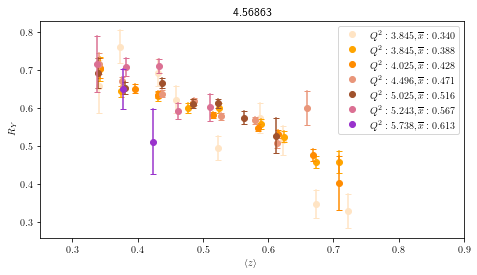

In [14]:
i_col = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','olive','orange','orangered','palevioletred','pink','red','royalblue','seagreen','sienna','slateblue','springgreen','tan','teal','thistle','tomato','wheat','yellow','bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','bisque','orange','darkorange','darksalmon','sienna','bisque','orange','darkorange','darksalmon','sienna']
Q2 = Q2s[1]

xs = df[df['Q2']==4.75].sort_values('xbj')['xbj'].unique()
#print(xs)
#ax.errorbar(xs,zs,RDs,RD_err,marker = "_")
fig = plt.figure()
ax = fig.add_subplot()
for ix in range(0,len(xs)):
    
    xbj = xs[ix]
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RY_alls = []
    xbj_corr_xbj = []
    xbj_err_xbj = []
    Q2_corr_xbj = []
    Q2_err_xbj = []
    zs = df[df['Q2']==4.75][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
    for iz in zs:
        z_hadron = zs
        RYs = []
        RYs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        
        for i,row in df[df['Q2']==4.75][df['xbj']==xs[ix]][df['z']==iz].iterrows():
            '''
            yield_neg = row['yield_neg']
            yield_pos = row['yield_pos']
            error_neg = row['error_neg']
            error_pos = row['error_pos']
            yield_ratio = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[0]
            yield_ratio_err = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[1]
            '''
            yield_ratio = row[RY_str]
            yield_ratio_err = row['error']
            
            RYs.append(yield_ratio)
            RYs_error.append(yield_ratio_err)
            zi_corr = row["z_corr"]
            zs_corr.append(zi_corr)
            zi_corr_err = row["z_corr_err"]
            zs_corr_err.append(zi_corr_err)
            xbji_corr = row["xbj_corr"]
            xbji_corr_err = row["xbj_corr_err"]
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = row["Q2_corr"]
            Q2i_corr_err = row["Q2_corr_err"]
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        Q2_corr_z = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        Q2_err_z = Get_weighted_sigma(Q2s_corr,Q2s_corr_err)
        Q2_corr_xbj.append(Q2_corr_z)
        Q2_err_xbj.append(Q2_err_z)
        xbj_corr_z = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_corr_err_z = Get_weighted_sigma(xbjs_corr,xbjs_corr_err)
        xbj_corr_xbj.append(xbj_corr_z)
        xbj_err_xbj.append(xbj_corr_err_z)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RY = Get_weighted_average(RYs,RYs_error)
        RY_err = Get_weighted_sigma(RYs,RYs_error)
        
        z_corrs.append(z_corr)
        RY_alls.append(RY)
        plt.plot([z_corr,z_corr],[RY+RY_err,RY-RY_err],marker = "_",color = colors_all[i_col])
    Q2_corr = Get_weighted_average(Q2_corr_xbj,Q2_err_xbj)
    xbj_corr = Get_weighted_average(xbj_corr_xbj,xbj_err_xbj)
    plt.plot(z_corrs,RY_alls,"o",label = f"$Q^2:{Q2_corr:.3f},\overline{{x}} :{xbj_corr:.3f}$",color = colors_all[i_col])#Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R_Y$')
    plt.xlim(0.25,0.9)
    plt.legend()
    #plt.ylim(0,10)
    plt.title(Q2)
    i_col +=1
    plt.savefig('notebook_results/RY_2ndQ2.pdf')

Text(0, 0.5, '$\\delta u$')

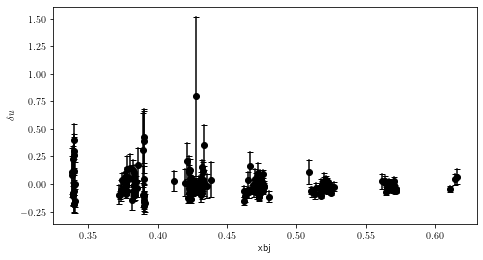

In [15]:
fig, ax = plt.subplots()
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "k")
plt.plot(xbj_twos_corr,CSV_twos,"ko",label = Q2)

#print(xbj_twos_corr)
    

#ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
#ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'MRST',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$\delta u$')

Text(0, 0.5, '$\\delta u$')

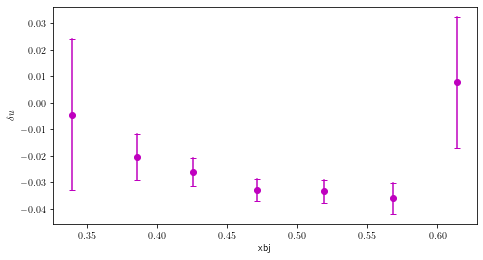

In [16]:
for i in range(len(CSV_twos_plot)):
    plt.plot([xbj_twos_plot[i],xbj_twos_plot[i]],[CSV_twos_plot[i]-CSV_twos_err_plot[i],CSV_twos_plot[i]+CSV_twos_err_plot[i]],marker = "_",color = "m")
plt.plot(xbj_twos_plot,CSV_twos_plot,"mo")
        

#ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
#ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$\delta u$')

Text(0, 0.5, '$CSV$')

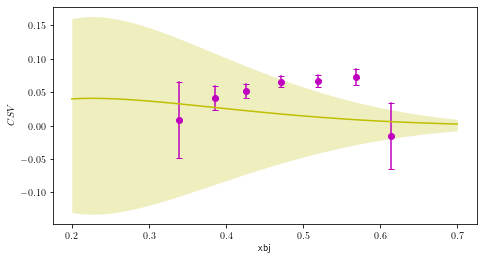

In [17]:
fig, ax = plt.subplots()
for i in range(len(CSV_twos_plot)):
    plt.plot([xbj_twos_plot[i],xbj_twos_plot[i]],[-2*CSV_twos_plot[i]-2*CSV_twos_err_plot[i],-2*CSV_twos_plot[i]+2*CSV_twos_err_plot[i]],marker = "_",color = "m")
plt.plot(xbj_twos_plot,-2*np.asarray(CSV_twos_plot),"mo")
        

ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$CSV$')

/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/3715727681.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zs = df[df['Q2']==5.5][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/3715727681.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in df[df['Q2']==5.5][df['xbj']==xs[ix]][df['z']==iz].iterrows():


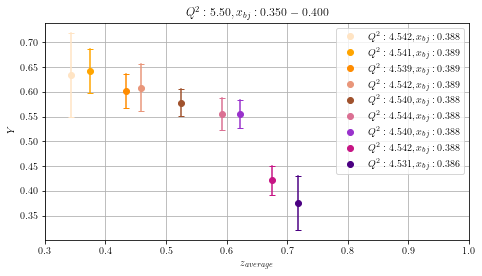

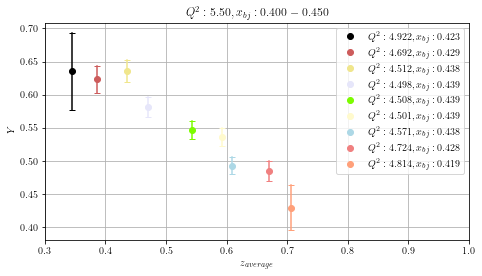

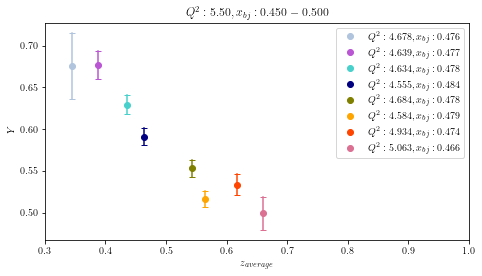

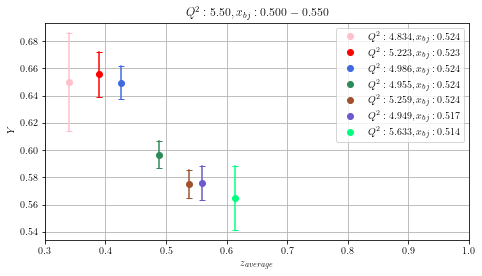

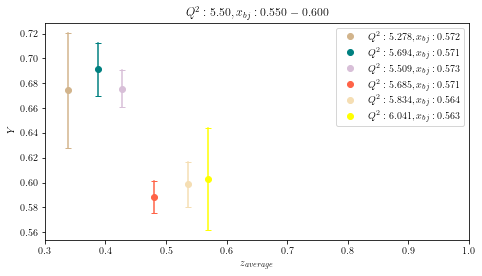

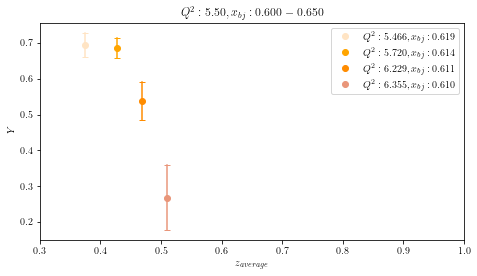

In [18]:

CSVs = []
CSVs_err = []
xbj_all_corr=[]
i_col = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','olive','orange','orangered','palevioletred','pink','red','royalblue','seagreen','sienna','slateblue','springgreen','tan','teal','thistle','tomato','wheat','yellow','bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','bisque','orange','darkorange','darksalmon','sienna','bisque','orange','darkorange','darksalmon','sienna']

xs = df[df['Q2']==5.5].sort_values('xbj')['xbj'].unique()
#print(xs)
#ax.errorbar(xs,zs,RDs,RD_err,marker = "_")
for ix in range(0,len(xs)):
    fig = plt.figure()
    ax = fig.add_subplot()
    xbj_three_corr = []
    xbj_three_err_corr = []
    CSV_three = []
    CSV_three_err = []
    #RD_err = []
    zs = df[df['Q2']==5.5][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
    #print(zs)
    xbj = xs[ix]
    for iz in zs:
        #print(iRunGroup)
        yield_ratios = []
        yield_ratio_errs = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        
        for i,row in df[df['Q2']==5.5][df['xbj']==xs[ix]][df['z']==iz].iterrows():
            zi_corr = row['z_corr']
            #print(z_corr)
            #yield_neg = row['yield_neg']
            #yield_pos = row['yield_pos']
            #error_neg = row['error_neg']
            #error_pos = row['error_pos']
            
            #print('RD_error ',RD_error)
            zs_corr.append(zi_corr)
            zi_corr_err = row["z_corr_err"]
            zs_corr_err.append(zi_corr_err)
            xbji_corr = row["xbj_corr"]
            xbji_corr_err = row["xbj_corr_err"]
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = row["Q2_corr"]
            Q2i_corr_err = row["Q2_corr_err"]
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            if Q2i_corr<3:
                print(Q2i_corr)
            yield_ratio = row[RY_str]
            yield_ratio_err = row['error']
            #yield_ratio = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[0]
            #yield_ratio_err = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[1]
            yield_ratios.append(yield_ratio)
            yield_ratio_errs.append(yield_ratio_err)
            CSVxzi =du_from_yield_ratio(math.sqrt(Q2i_corr),xbji_corr,zi_corr,yield_ratio,yield_ratio_err)[0]
            CSVxzi_err =du_from_yield_ratio(math.sqrt(Q2i_corr),xbji_corr,zi_corr,yield_ratio,yield_ratio_err)[1]
            #CSVxzi_err = CSVx_err(math.sqrt(Q2i_corr),zi_corr,xbji_corr,RDi_error)
            CSV_threes.append(CSVxzi)
            CSV_threes_err.append(CSVxzi_err)
            xbj_threes_corr.append(xbji_corr)
            #print(xbji_corr)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        xbj_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        #print(xbj_corr)
        if abs(xbj_corr-xbj)>0.025:
            print(xbj_corr-xbj)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        Q2_corr = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        if Q2_corr<3:
            print("corr ",Q2_corr)
        yield_ratio_xi = Get_weighted_average(yield_ratios,yield_ratio_errs)
        yield_ratio_xi_err = Get_weighted_sigma(yield_ratios,yield_ratio_errs)
        ax.plot([z_corr,z_corr],[yield_ratio_xi+yield_ratio_xi_err,yield_ratio_xi-yield_ratio_xi_err],color = colors_all[i_col],marker = "_")
        plt.plot(z_corr,yield_ratio_xi,"o",color = colors_all[i_col],label = f"$Q^2:{Q2_corr:.3f},x_{{bj}}:{xbj_corr:.3f}$")
        xbj_all_corr.append(xbj_corr)
        #here CSV is combined for same kin point for plotting reason
        CSVxi = du_from_yield_ratio(math.sqrt(Q2_corr),xbj_corr,z_corr,yield_ratio_xi,yield_ratio_xi_err)[0]
        CSVxi_err = du_from_yield_ratio(math.sqrt(Q2_corr),xbj_corr,z_corr,yield_ratio_xi,yield_ratio_xi_err)[1]
        CSVs.append(CSVxi)
        CSVs_err.append(CSVxi_err)
        xbj_three_corr.append(xbj_corr)
        xbj_threei_err_corr = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_three_err_corr.append(xbj_threei_err_corr)
        CSV_three.append(CSVxi)
        CSV_three_err.append(CSVxi_err)
        plt.xlabel(r'$z_{average}$')
        plt.ylabel(r'$Y$')
        plt.xlim(0.3,1)
        plt.legend()
        plt.grid()
        ax.set_title(f"$Q^2:{Q2_str[2][0:4]},x_{{bj}}:{(xbj-0.025):.3f}-{(xbj+0.025):.3f}$")#str(xbj-0.025)[0:5]+"-"+str(xbj+0.025)[0:5])
        i_col = i_col+1
                    
    xbj_three = Get_weighted_average(xbj_three_corr,xbj_three_err_corr)
    xbj_threes_plot.append(xbj_three)
    #print(xbj_three_corr)
    #print('corredted',xbj_three)
    xbj_three_err = Get_weighted_average(xbj_three_corr,xbj_three_err_corr)
    #xbj_threes_err.append(xbj_three_err)
    #print('CSVs',CSV_three)
    #print('CSCVs err',CSV_three_err)
    CSVxi_three = Get_weighted_average(CSV_three,CSV_three_err)
    CSVxi_three_err = Get_weighted_sigma(CSV_three,CSV_three_err)
    #print('CSV three', CSVxi_three)
    #print('CSV three err',CSVxi_three_err)
    #print(CSV_three_err)
    #print(CSVxi_three_err)
    
    CSV_threes_plot.append(CSVxi_three)
    CSV_threes_err_plot.append(CSVxi_three_err)
    sys_out = "5.5,"+str(xbj)+","+str(xbj_three)+","+FF_model[i_FF]+","+PDF_model[i_PDF]+","+str(i_rho)+","+str(CSVxi_three)+","+str(CSVxi_three_err)+"\n"
        #sys_out = ['4',str(Q2_corr),str(ix),str(xbj_corr),str(iz),str(z_corr),FF_model[i_FF],str(i_rho)]
    with open('results/csv_systematic.txt','a',encoding='UTF8') as f_sys:
        f_sys.write(sys_out)

/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/1392253771.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  zs = df[df['Q2']==5.5][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
/var/folders/ll/8_2_l77j4yl2zjb6stl8d9b00000gn/T/ipykernel_22125/1392253771.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for i,row in df[df['Q2']==5.5][df['xbj']==xs[ix]][df['z']==iz].iterrows():


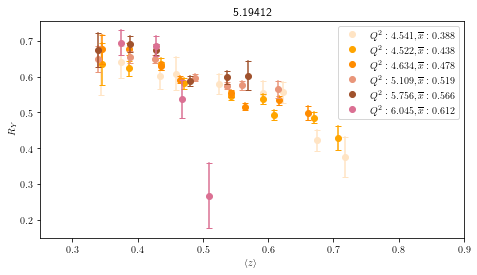

In [19]:
i_col = 0
colors_all = ['bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','olive','orange','orangered','palevioletred','pink','red','royalblue','seagreen','sienna','slateblue','springgreen','tan','teal','thistle','tomato','wheat','yellow','bisque','orange','darkorange','darksalmon','sienna','palevioletred','darkorchid','mediumvioletred','indigo','black','indianred','khaki','lavender','lawngreen','lemonchiffon','lightblue','lightcoral','lightsalmon','lightsteelblue','mediumorchid','mediumturquoise','navy','bisque','orange','darkorange','darksalmon','sienna','bisque','orange','darkorange','darksalmon','sienna']
Q2 = Q2s[2]

xs = df[df['Q2']==5.5].sort_values('xbj')['xbj'].unique()
#print(xs)
#ax.errorbar(xs,zs,RDs,RD_err,marker = "_")
fig = plt.figure()
ax = fig.add_subplot()
for ix in range(0,len(xs)):
    
    xbj = xs[ix]
    #fig = plt.figure()
    #ax = fig.add_subplot()
    z_corrs = []
    RY_alls = []
    xbj_corr_xbj = []
    xbj_err_xbj = []
    Q2_corr_xbj = []
    Q2_err_xbj = []
    zs = df[df['Q2']==5.5][df['xbj']==xs[ix]].sort_values('z')['z'].unique()
    for iz in zs:
        z_hadron = zs
        RYs = []
        RYs_error = []
        zs_corr = []
        zs_corr_err = []
        xbjs_corr = []
        xbjs_corr_err = []
        Q2s_corr = []
        Q2s_corr_err = []
        
        for i,row in df[df['Q2']==5.5][df['xbj']==xs[ix]][df['z']==iz].iterrows():
            '''
            yield_neg = row['yield_neg']
            yield_pos = row['yield_pos']
            error_neg = row['error_neg']
            error_pos = row['error_pos']
            yield_ratio = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[0]
            yield_ratio_err = Get_Yield_ratio(yield_pos,error_pos,yield_neg,error_neg)[1]
            '''
            yield_ratio = row[RY_str]
            yield_ratio_err = row['error']
            RYs.append(yield_ratio)
            RYs_error.append(yield_ratio_err)
            zi_corr = row["z_corr"]
            zs_corr.append(zi_corr)
            zi_corr_err = row["z_corr_err"]
            zs_corr_err.append(zi_corr_err)
            xbji_corr = row["xbj_corr"]
            xbji_corr_err = row["xbj_corr_err"]
            xbjs_corr.append(xbji_corr)
            xbjs_corr_err.append(xbji_corr_err)
            Q2i_corr = row["Q2_corr"]
            Q2i_corr_err = row["Q2_corr_err"]
            Q2s_corr.append(Q2i_corr)
            Q2s_corr_err.append(Q2i_corr_err)
            #ax.plot([z_corr,z_corr],[RD+RD_error,RD-RD_error],marker="_",color = colors[RunGroup//10])
        Q2_corr_z = Get_weighted_average(Q2s_corr,Q2s_corr_err)
        Q2_err_z = Get_weighted_sigma(Q2s_corr,Q2s_corr_err)
        Q2_corr_xbj.append(Q2_corr_z)
        Q2_err_xbj.append(Q2_err_z)
        xbj_corr_z = Get_weighted_average(xbjs_corr,xbjs_corr_err)
        xbj_corr_err_z = Get_weighted_sigma(xbjs_corr,xbjs_corr_err)
        xbj_corr_xbj.append(xbj_corr_z)
        xbj_err_xbj.append(xbj_corr_err_z)
        z_corr = Get_weighted_average(zs_corr,zs_corr_err)
        RY = Get_weighted_average(RYs,RYs_error)
        RY_err = Get_weighted_sigma(RYs,RYs_error)
        
        z_corrs.append(z_corr)
        RY_alls.append(RY)
        plt.plot([z_corr,z_corr],[RY+RY_err,RY-RY_err],marker = "_",color = colors_all[i_col])
    Q2_corr = Get_weighted_average(Q2_corr_xbj,Q2_err_xbj)
    xbj_corr = Get_weighted_average(xbj_corr_xbj,xbj_err_xbj)
    plt.plot(z_corrs,RY_alls,"o",label = f"$Q^2:{Q2_corr:.3f},\overline{{x}} :{xbj_corr:.3f}$",color = colors_all[i_col])#Q2,r'$ x $',str(xbj_corr)[0:5]),color = colors_all[i_color])
    #r'$\langle B_{\mathrm{e}} \rangle$'
    plt.xlabel(r'$\langle z \rangle$')
    plt.ylabel(r'$R_Y$')
    plt.xlim(0.25,0.9)
    plt.legend()
    #plt.ylim(0,10)
    plt.title(Q2)
    i_col +=1
    plt.savefig('notebook_results/RY_3rdQ2.pdf')

Text(0, 0.5, '$\\delta u$')

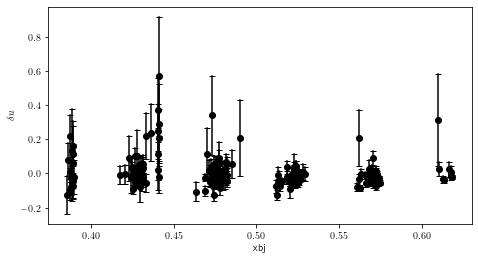

In [20]:
fig, ax = plt.subplots()
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "k")
plt.plot(xbj_threes_corr,CSV_threes,"ko",label = Q2)

#print(xbj_threes_corr)
    

#ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
#ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'MRST',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$\delta u$')

Text(0, 0.5, '$\\delta u$')

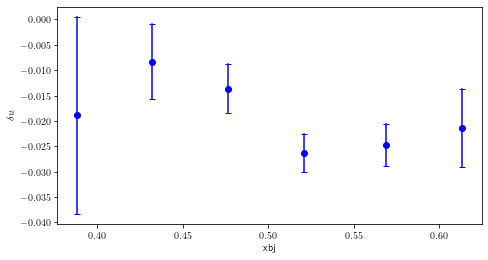

In [21]:
for i in range(len(CSV_threes_plot)):
    plt.plot([xbj_threes_plot[i],xbj_threes_plot[i]],[CSV_threes_plot[i]-CSV_threes_err_plot[i],CSV_threes_plot[i]+CSV_threes_err_plot[i]],marker = "_",color = "b")
plt.plot(xbj_threes_plot,CSV_threes_plot,"bo")
        

#ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
#ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$\delta u$')

Text(0, 0.5, '$CSV$')

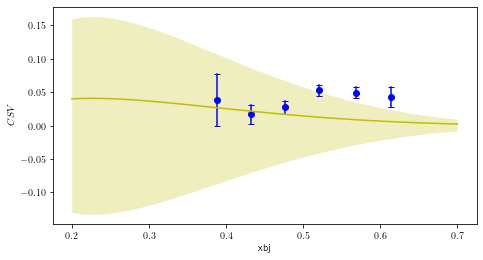

In [22]:
fig, ax = plt.subplots()
for i in range(len(CSV_threes_plot)):
    plt.plot([xbj_threes_plot[i],xbj_threes_plot[i]],[-2*CSV_threes_plot[i]-2*CSV_threes_err_plot[i],-2*CSV_threes_plot[i]+2*CSV_threes_err_plot[i]],marker = "_",color = "b")
plt.plot(xbj_threes_plot,-2*np.asarray(CSV_threes_plot),"bo")
        

ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'CSV',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$CSV$')

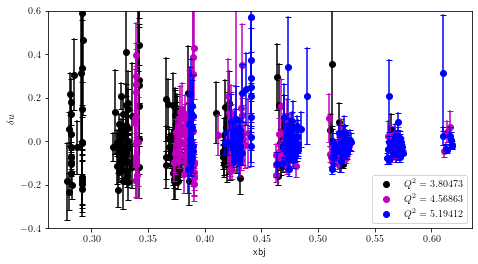

In [23]:
fig, ax = plt.subplots()   
for i in range(len(CSV_ones)):
    plt.plot([xbj_ones_corr[i],xbj_ones_corr[i]],[CSV_ones[i]-CSV_ones_err[i],CSV_ones[i]+CSV_ones_err[i]],marker = "_",color = "k")
plt.plot(xbj_ones_corr,CSV_ones,"ko",label = r'$Q^2 = {}$'.format(Q2s[0]))
for i in range(len(CSV_twos)):
    plt.plot([xbj_twos_corr[i],xbj_twos_corr[i]],[CSV_twos[i]-CSV_twos_err[i],CSV_twos[i]+CSV_twos_err[i]],marker = "_",color = "m")
plt.plot(xbj_twos_corr,CSV_twos,"mo",label = r'$Q^2 = {}$'.format(Q2s[1]))
for i in range(len(CSV_threes)):
    plt.plot([xbj_threes_corr[i],xbj_threes_corr[i]],[CSV_threes[i]-CSV_threes_err[i],CSV_threes[i]+CSV_threes_err[i]],marker = "_",color = "b")
plt.plot(xbj_threes_corr,CSV_threes,"bo",label = r'$Q^2 = {}$'.format(Q2s[2]))


     
#ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
#ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'MRST',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$\delta u$')
plt.ylim(-0.4,0.6)
plt.legend()
plt.savefig(f"results/delta_u_{pdf_name}.pdf")
#plt.savefig("results/delta_u_equation1.pdf")
#plt.savefig("results/delta_u_equation2.pdf")

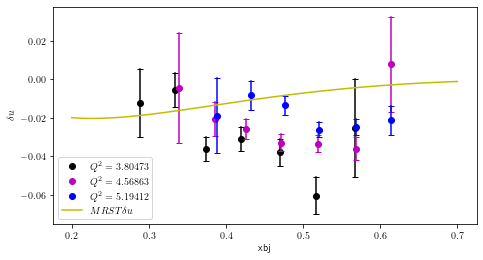

In [24]:

#CSV = -(1+a)deltau
fig, ax = plt.subplots()   
for i in range(len(CSV_ones_plot)):
    plt.plot([xbj_ones_plot[i],xbj_ones_plot[i]],[CSV_ones_plot[i]+CSV_ones_err_plot[i],CSV_ones_plot[i]-CSV_ones_err_plot[i]],marker = "_",color = "k")
plt.plot(xbj_ones_plot,np.asarray(CSV_ones_plot),"ko",label = r'$Q^2 = {}$'.format(Q2s[0]))
for i in range(len(CSV_twos_plot)):
    plt.plot([xbj_twos_plot[i],xbj_twos_plot[i]],[CSV_twos_plot[i]+CSV_twos_err_plot[i],CSV_twos_plot[i]-CSV_twos_err_plot[i]],marker = "_",color = "m")
plt.plot(xbj_twos_plot,np.asarray(CSV_twos_plot),"mo",label = r'$Q^2 = {}$'.format(Q2s[1]))
for i in range(len(CSV_threes_plot)):
    plt.plot([xbj_threes_plot[i],xbj_threes_plot[i]],[CSV_threes_plot[i]+CSV_threes_err_plot[i],CSV_threes_plot[i]-CSV_threes_err_plot[i]],marker = "_",color = "b")
plt.plot(xbj_threes_plot,np.asarray(CSV_threes_plot),"bo",label = r'$Q^2 = {}$'.format(Q2s[2]))


     
#ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_uv,label = r'$MRST \delta u$',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$\delta u$')
#plt.ylim(-0.15,0.2)
plt.legend()
plt.savefig(f"results/deltau_{pdf_name}.pdf")
#plt.savefig("results/CSV_equation2.pdf")
#plt.savefig("results/CSV_equation1.pdf")

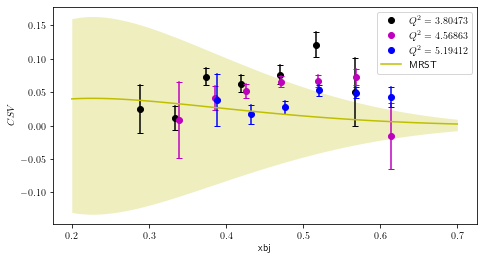

In [25]:

#CSV = -(1+a)deltau
fig, ax = plt.subplots()   
for i in range(len(CSV_ones_plot)):
    plt.plot([xbj_ones_plot[i],xbj_ones_plot[i]],[-(1+a)*CSV_ones_plot[i]+(1+a)*CSV_ones_err_plot[i],-(1+a)*CSV_ones_plot[i]-(1+a)*CSV_ones_err_plot[i]],marker = "_",color = "k")
plt.plot(xbj_ones_plot,-(1+a)*np.asarray(CSV_ones_plot),"ko",label = r'$Q^2 = {}$'.format(Q2s[0]))
for i in range(len(CSV_twos_plot)):
    plt.plot([xbj_twos_plot[i],xbj_twos_plot[i]],[-(1+a)*CSV_twos_plot[i]+(1+a)*CSV_twos_err_plot[i],-(1+a)*CSV_twos_plot[i]-(1+a)*CSV_twos_err_plot[i]],marker = "_",color = "m")
plt.plot(xbj_twos_plot,-(1+a)*np.asarray(CSV_twos_plot),"mo",label = r'$Q^2 = {}$'.format(Q2s[1]))
for i in range(len(CSV_threes_plot)):
    plt.plot([xbj_threes_plot[i],xbj_threes_plot[i]],[-(1+a)*CSV_threes_plot[i]+(1+a)*CSV_threes_err_plot[i],-(1+a)*CSV_threes_plot[i]-(1+a)*CSV_threes_err_plot[i]],marker = "_",color = "b")
plt.plot(xbj_threes_plot,-(1+a)*np.asarray(CSV_threes_plot),"bo",label = r'$Q^2 = {}$'.format(Q2s[2]))


     
ax.fill_between(x_axis,y_delta_uv_up-y_delta_uv_low,y_delta_dv_up-y_delta_dv_low,color = 'y',alpha=.25, linewidth=0)
ax.plot(x_axis,y_delta_dv-y_delta_uv,label = 'MRST',color = 'y')
#plt.plot(x_axis,y_delta_dv_up-y_delta_dv_low,'--',color = 'r')
plt.xlabel('xbj')
plt.ylabel(r'$CSV$')
#plt.ylim(-0.15,0.2)
plt.legend()
plt.savefig(f"results/CSV_{pdf_name}.pdf")
#plt.savefig("results/CSV_equation2.pdf")
#plt.savefig("results/CSV_equation1.pdf")